In [1]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
#alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
#the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
#again, uDFT = R^{-1}.DFT

In [24]:
#for u in GF(q), we can factor as u=aa^*=aa^q=a^{q+1} in GF(q**2) using gen. z and modular arithmetic
def conj_sqrt(u):
    if u == 0:
        return 0
    z = u.parent().multiplicative_generator()
    k = u.log(z)  # Compute discrete log of u to the base z
    if k % (q+1) != 0:
        raise ValueError("exponent must be divisible by q+1")
    return z ** (k//(q+1))

In [25]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft():
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_sqrt(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [26]:
#parameters and define the symmetric group algebra
n = 3; q = 11
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n) # F[S_n], group algebra
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(SGA.group().cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [27]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft(); U.str()

'[ 7*z2 + 7  7*z2 + 7  7*z2 + 7  7*z2 + 7  7*z2 + 7  7*z2 + 7]\n[ 2*z2 + 8    z2 + 4  9*z2 + 3 10*z2 + 7 10*z2 + 7    z2 + 4]\n[        0  6*z2 + 7         0  6*z2 + 7  5*z2 + 4  5*z2 + 4]\n[        0 10*z2 + 9         0    z2 + 2 10*z2 + 9    z2 + 2]\n[ 2*z2 + 8 10*z2 + 7  2*z2 + 8 10*z2 + 7 10*z2 + 7 10*z2 + 7]\n[ 7*z2 + 7  4*z2 + 4  4*z2 + 4  7*z2 + 7  7*z2 + 7  4*z2 + 4]'

In [28]:
#check that U is unitary over a finite field. .H is conjugate-transpose
U*U.H == 1

True

In [29]:
#given a multiplicative generator `z` of the finite field, the discrete_log is the exponent of the generator
#the discrete_log of zero is -infinity, which we set to -1 for convenience since all other values are nonnegative
discrete_log = lambda F, x: x.log(F.multiplicative_generator()) if x != 0 else -1

In [30]:
#compute the discrete log of each entry of U
log_U = U.apply_map(lambda x: discrete_log(F,x))

In [125]:
log_U

[111 111 111 111 111 111]
[112 100  52  40  40 100]
[ -1  68  -1  68   8   8]
[ -1 118  -1  58 118  58]
[112  40 112  40  40  40]
[111  51  51 111 111  51]

In [124]:
"""
plot the discrete log of a matrix valued in a finite field
since log(0) = -infinity, we set this to -1, and color it black

- F is the field
- M is a matrix of discrete log values of elements of F

BUG: this is not working for large splitting fields, when the matrix values are ~7 digits
"""
def plot_discrete_log(F, M):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm

    cmap = plt.cm.hsv  # Get the HSV colormap
    num_colors = max(F.order(), 256) #for large fields we can't use that many colors, set a cutoff
    new_colors = np.vstack(([0, 0, 0, 1], cmap(np.linspace(0, 1, num_colors))))
    custom_cmap = ListedColormap(new_colors) # create a new custom colormap
    norm = BoundaryNorm([-1] + list(np.linspace(0, F.order()-1, num_colors)), custom_cmap.N) #map -1 to black

    # Plotting the data
    plt.imshow(M, cmap=custom_cmap, norm=norm, interpolation="nearest")
    plt.colorbar()
    plt.show()

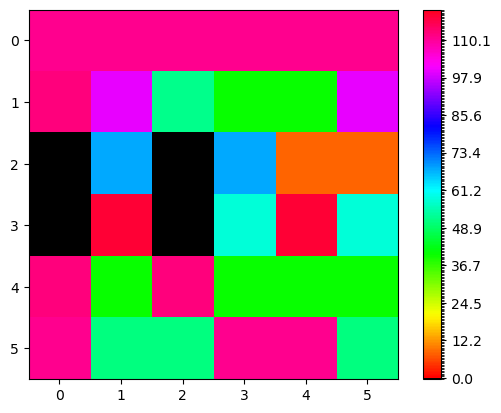

In [123]:
plot_discrete_log(F,log_U)

In [34]:
#the map from modular representation theory to compute Brauer characters from F_q --> \C giving roots of unity
#note: Brauer character is the rep'n matrix eigenvalues (over a splitting field extension of F_q) mapped to \C using Brauer map and summed
#i.e. let \alpha = g^k |--> \exp(2*pi*i*k/(q-1))
#i.e. F_q^* is cyclic of order q-1, mapping to (q-1)^th roots of unity in \C
brauer_map = lambda a, F: 0 if a == 0 else exp(2*pi*I*a.log(F.multiplicative_generator())/(F.order()-1))

In [35]:
#complexify the uDFT matrix over F_q using the Brauer map
U_complex = matrix(CC,U.apply_map(lambda a: brauer_map(a,F)))

In [36]:
#compute the Gram matrix, taking inner products of rows and columns w.r.t conjugate inner product
#note: want this to be the identity matrix (so it would be unitary over \C), but currently it is not quite
#unitary matrices are required if they are to be used as operators in quantum computing
gram = U_complex*U_complex.H

In [37]:
#function to round each component of a complex number 
def round_complex(z, digits):
    if z.imag_part():
        return round(z.real_part(), digits) + round(z.imag_part(), digits) * I
    return round(z, digits)

In [38]:
#round the (complex) Gram matrix to three decimal places
gram_rounded = gram.apply_map(lambda u:round_complex(u,3))

In [39]:
#plot the complexified version of the uDFT matrix over a finite field
def plot_complex(U_complex):
    U_arg = U_complex.apply_map(lambda x: arg(x))  # find the argument of each element
    return matrix_plot(U_arg, cmap='hsv', colorbar=True)  # plot the matrix

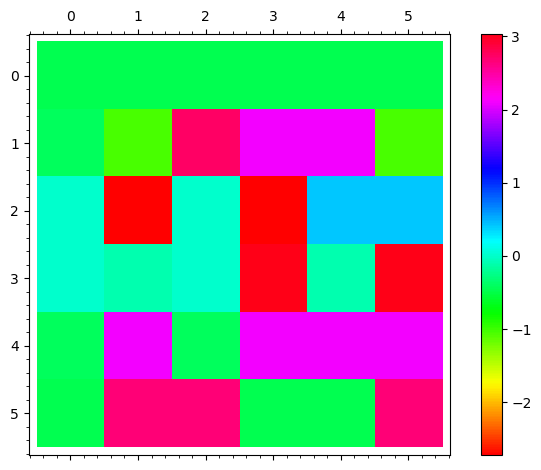

In [40]:
#plot the complexified version of the uDFT matrix over a finite field
plot_complex(U_complex)

In [41]:
#check that Gram matrix is conjugate symmetric (should be since it is U*U.H)
gram_rounded == gram_rounded.H

True

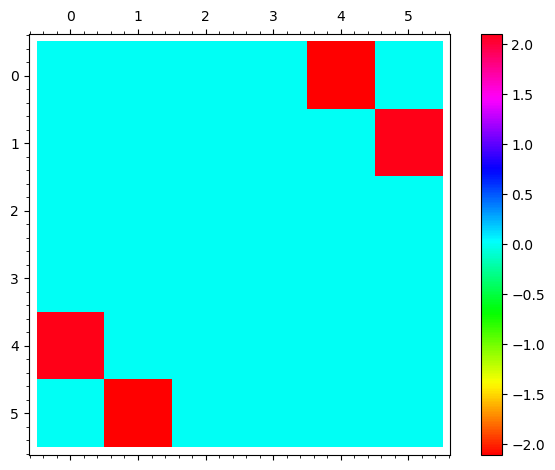

In [42]:
#plot the result of U_complex*U_complex.H to see how far it is from being unitary over the complex numbers
plot_complex(gram_rounded)

In [43]:
#compute the eigenvalues of the uDFT matrix
eigenvalues = U.eigenvalues(); eigenvalues

[9*z6^5 + z6^4 + 3*z6^3 + z6^2 + 2, 8*z6^5 + 3*z6^4 + 8*z6^3 + 7*z6^2 + 4, 10*z6^4 + 6*z6^3 + 4*z6^2 + 7*z6 + 8, 9*z6^5 + 9*z6^4 + 10*z6^3 + 8*z6^2 + 2*z6 + 6, 4*z6^5 + 10*z6^4 + 3*z6^3 + 2*z6^2 + 3*z6 + 6, 8*z6^5 + 8*z6^4 + 8*z6^3 + 10*z6^2 + 3*z6 + 9]

In [102]:
#compute the maximum degree required for the eigenvalues
#this should agree with the splitting field degree, but sometimes it doesn't
max_deg_eigs = max([eig.minpoly().degree() for eig in eigenvalues])

In [44]:
#compute the multiplicity of each eigenvalue. check if all eigenvalues are distinct
from collections import Counter
multiplicities = Counter(eigenvalues)
all_unique = all(count == 1 for count in multiplicities.values()); all_unique

True

In [45]:
#compute the charpoly of the uDFT matrix 
charpoly = U.minimal_polynomial(); charpoly

x^6 + (10*z2 + 9)*x^5 + (z2 + 8)*x^4 + (2*z2 + 8)*x^3 + (5*z2 + 5)*x^2 + (z2 + 2)*x + z2 + 3

In [103]:
#compute a splitting field of the characteristic polynomial
K = GF(q**max_deg_eigs); print(f"field containing all eigenvalues: K = {K}")
L = charpoly.splitting_field('a'); print(f"splitting field: L = {L}")
print(K.multiplicative_generator().minimal_polynomial())

field containing all eigenvalues: K = Finite Field in z6 of size 11^6
splitting field: L = Finite Field in a of size 11^6
x^6 + 3*x^4 + 4*x^3 + 6*x^2 + 7*x + 2


In [104]:
#compute the eigenvalues over a specific field K rather than using the algebraic closure
eigenvalues_K = matrix(K,U).eigenvalues(extend=False)

In [105]:
#compute the discrete log of the eigenvalues
log_eigenvalues = list(map(lambda x: discrete_log(K,x), eigenvalues_K)); log_eigenvalues

[951760, 1644400, 160000, 557680, 1398760, 11560]

In [106]:
#compute the complexified eigenvalue
complex_eigenvalues = [brauer_map(eig,K) for eig in eigenvalues_K]

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eig.real() for eig in complex_eigenvalues]
imaginary_parts = [eig.imag() for eig in complex_eigenvalues]

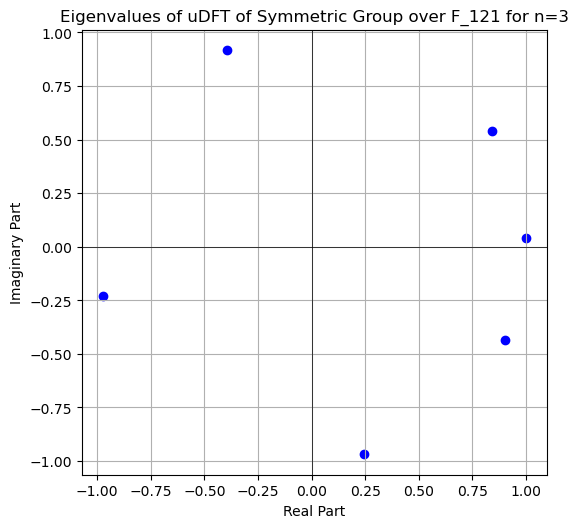

In [108]:
# Plotting the eigenvalues on the complex plane
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'Eigenvalues of uDFT of Symmetric Group over F_{q**2} for n={n}')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

In [109]:
#compute the eigenvectors over a splitting field
D, P = matrix(L,U).eigenmatrix_right()

In [110]:
def dump_eigenvector_matrix(P):
    """
    dump the eigenvector matrix into a .csv file
    """
    with open(f"data/eigenvectors_unitary_dft_symmetric_group_finite_field_n={n}_q={q}.csv", "w") as f:
        for row in P:
            f.write(",".join(map(str, row)) + "\n")

In [111]:
dump_eigenvector_matrix(P)

In [112]:
#take the discrete log of the eigenvector matrix
log_P = P.apply_map(lambda x: discrete_log(L,x)); log_P

[      0       0       0       0       0       0]
[1361556 1344996 1197036 1532556  948276 1764756]
[1295414 1079874 1033794 1340874 1606574  847814]
[1172199  299109 1730109  760989 1063839  111279]
[ 275637  852166 1236886  361606 1759197 1463997]
[ 385973  365211  486171 1673091 1525853  642173]

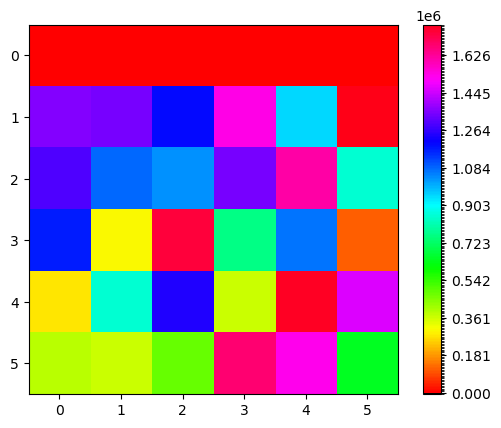

In [120]:
#plot the discrete log of the eigenvector matrix P
plot_discrete_log(L,log_P)

In [95]:
def dump_discrete_log(L, P):
    """
    - compute the discrete log of each entry of P, the eigenvector matrix of the uDFT of S_n over F_{q^2}
    - write the resulting matrix to a comma separated value file
    - include a progress bar since computing discrete logs for large fields takes a long time
    """
    total = P.nrows() * P.ncols()
    count = 0
    filename = f"data/discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
    with open(filename, "w") as f:
        for i in range(P.nrows()):
            for j in range(P.ncols()):
                log_value = discrete_log(L, P[i, j])
                f.write(str(log_value))
                if j != P.ncols()-1:
                    f.write(",")
                count += 1
                # Print progress as a percentage
                progress = float(count) / total * 100
                print(f"Progress: {progress:.2f}%\n", end="")
            f.write("\n")
    return "done"

In [94]:
dump_discrete_log(L, P)

Progress: 2.78%
Progress: 5.56%
Progress: 8.33%
Progress: 11.11%
Progress: 13.89%
Progress: 16.67%
Progress: 19.44%
Progress: 22.22%
Progress: 25.00%
Progress: 27.78%
Progress: 30.56%
Progress: 33.33%
Progress: 36.11%
Progress: 38.89%
Progress: 41.67%
Progress: 44.44%
Progress: 47.22%
Progress: 50.00%
Progress: 52.78%
Progress: 55.56%
Progress: 58.33%
Progress: 61.11%
Progress: 63.89%
Progress: 66.67%
Progress: 69.44%
Progress: 72.22%
Progress: 75.00%
Progress: 77.78%
Progress: 80.56%
Progress: 83.33%
Progress: 86.11%
Progress: 88.89%
Progress: 91.67%
Progress: 94.44%
Progress: 97.22%
Progress: 100.00%


'done'